<a href="https://colab.research.google.com/github/pkro/tensorflow_cert_training/blob/main/handsonml/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task: use california census data to build a model of housing prices. The model should predict the median housing price in any district.

## Frame the problem


```
# This is formatted as code
```




### Objective
- What is the objective / How will the model be used? *results are fed into another ML pilepine*
- What if the current solution? *manual analysis*
- How will performance be measured?
- Will data be used as-is or e.g. clustered (categorized), in which case we could do this step in our own model OR have a lower precision as the individual prices will not be used

### What kind of training?

- *Univariate regression problem as the model will be used to predict one (=univariate as opposed to multivariate) value*
- *Supervised learning (for now) as we have one blob of data*; later maybe unsupervised if more data comes in.
- *batch learning as the data is relatively small*

### Select a performance measure

- Typical: Root mean squared error, which penalizes large errors more; sensitive to outliers
- If there are many outliers, mean absolute error (MAE)

## Get the Data

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

In [4]:
housing = load_housing_data()

## Get an overview / explore the data

In [5]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

There seems to be 9 (possible) independent variables and the dependent variable to be predicted (`median_house_value`)

In [6]:
# Get more info about datatypes and possibly missing values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There seems to be some missing data for `total_bedrooms`.

In [7]:
# check the only variable with object type
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# get some standard statistical data about the data
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

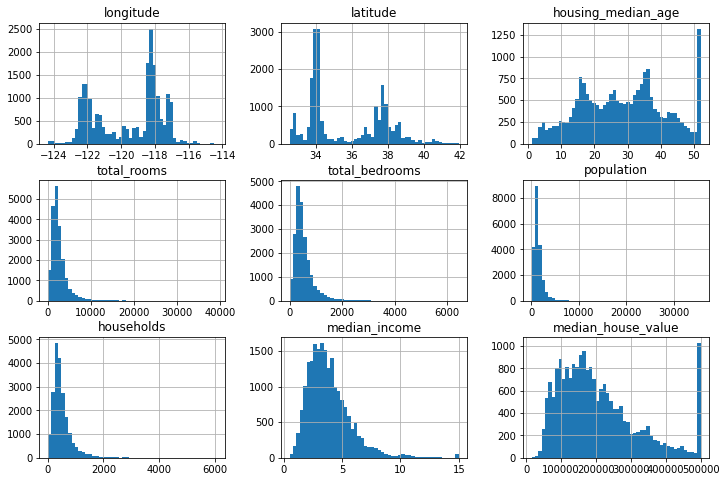

In [9]:
# Plot a histogramm for the numerical values
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))
plt.show()b

Insights:

- The median income seems too low to be in USD (0-15). *investigation in the source / description of the dataset shows that the data represents 10.000 of dolars per unit and that it is capped at 0.5 and 15*
- median age and value seems to be capped at 50 / 500.000 respectively *2 options here, get data for > 500.000 or remove capped datasets at the possible cost of the model not being able to accurately predict prices > 500.000*
- Many histograms are skewed right (more units "to the right" of the graph); may be converted to be bell shaped later



## Create a test set

Create a test set *before* looking more closely into the data to avoid the decision which kind of algorithm to use to be biased by perceived patterns in the data.

Problems:

- what happens when more data becomes available? Use the old test set or create a new one? How to ensure that former test data doesn't bleed into the new trainig set when a new random selection is done? If using just the old test set, is it still representative of the new data? Goal is that the new test set still contains 20% of the new instances, but not contain any instance that was previously in the training set. *a solution to this problem is shown int the book (basically hashing some unique row identifier to check if it exists in the training set)*
- many values are clustered in small ranges. A purely random selection may have a sampling bias, so that values outside the clusters (e.g. incomes above 7) are not well represented in the test set. Solution: stratifying

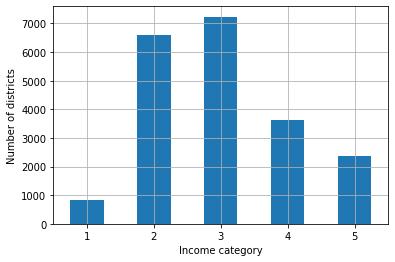

In [12]:
# create income category to stratify / represent incomes over the whole dataset.
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])


housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
# use stratified sampling and split into train / test
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)